# Case Study: Fraud Detection

## Goals of this notebook:
- Show the use of GridSearch for hyperparameter optimization
- Run XGBoost: an efficient decision-tree boosting method


In [1]:
# Class to create Matlab-like structure
class matlab_like():
    pass

## Context


Ref: https://www.kaggle.com/mlg-ulb/creditcardfraud

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## Library

In [2]:
import time
import scipy.stats as stats
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler # to normalize feats
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [ ]:
import numpy as np

# Define my metrics
def ji_get_metrics(C):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    
    Good reading: http://stats.stackexchange.com/questions/49579/balanced-accuracy-vs-f-1-score
    
    """
    
    allres = matlab_like()
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1]
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN
    TPR = tp / (NP+0.) # Sensitivity or Recall_P
    TNR = tn / (NN+0.) # Specificity or Recall_N
    
    print(' TN=%d, FP=%d'%(tn,fp))
    print(' FN=%d, TP=%d'%(fn,tp))
        
    
    precision = (tp/(tp+fp+0.)) # Precision_P
    recall = TPR
    
    allres.C0 = TNR
    allres.C1 = TPR
    allres.Precision = precision
    allres.Recall = recall
    allres.BAcc = (TPR+TNR)/2 
    allres.F1 = 2*((precision*recall)/(precision+recall))
    
    return allres

In [4]:
# Function to plot Confusion Matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# Standardize or normalize
def ji_normalize(df,typeN,selectedCol):
    # Return a normalized DF
    # Use: dd = ji_normalize(df,'minmax',['colName'])

    dfx = df.copy()
    if selectedCol:
        if typeN == 'minmax':
            dfx[selectedCol] = dfx[selectedCol].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        else:
            dfx[selectedCol] = StandardScaler().fit_transform(dfx[selectedCol].values.reshape(-1, 1))
    else:
        allcols = dfx.columns
        if typeN == 'minmax':
            dfx[allcols] = dfx[allcols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        else:
            dfx[allcols] = StandardScaler().fit_transform(dfx[allcols].values)
        
    return dfx
    

## Load the data set

In [6]:
# 1) Import data
df = pd.read_csv("0_data/creditcard.csv")
df.head() # notice that the features are anonymized

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# If you want to alter/categorize or fix a particular categorical variable (not the case here...)
def val_update(val):
    if val<0:
        return 0
    else:
        return 1
#aux = df['V1'].apply(val_update)
#aux.head()

In [8]:
# Check if there are missing values 
# --> NO!
#df.isnull().sum()

In [9]:
# Original data to keep:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Prepare training & validation & testing

In [10]:
# ORIGINAL DATA
# - df
# - x_data
# - y_labels

# 2) Prepare the learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

x_data = df.drop('Class',axis=1)
y_labels = df['Class']
y_names = ['Normal','Fraud']

X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

print('Train+Validation:%s, Test:%s'%(X_train.shape,X_test.shape))

# 2.a) Random Cross Validation (10-folds)
k_3folds = KFold(n_splits=3,random_state=101)
k_5folds = KFold(n_splits=5,random_state=101)
k_10folds = KFold(n_splits=10,random_state=101)
for train_indices, validation_indices in k_5folds.split(X_train):
     print('Index,Train: %s|Valid: %s' % (train_indices, validation_indices))

# 2.b) Stratified Cross Validation (10-folds) - distributed based on labels
sk_3folds = StratifiedKFold(n_splits=3, random_state=101)
sk_5folds = StratifiedKFold(n_splits=5, random_state=101)
sk_10folds = StratifiedKFold(n_splits=10, random_state=101)

# Showing ratio
dfaux = y_train
print("")
print("** Train+Validation Data **")
print("Percentage of normal transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 0])/float(len(dfaux)),len(dfaux[dfaux == 0])))
print("Percentage of fraud transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 1])/float(len(dfaux)),len(dfaux[dfaux == 1])))
print("Total number of transactions in resampled data: %d"%(len(dfaux)))
# Showing ratio
dfaux = y_test
print("")
print("** Test Data **")
print("Percentage of normal transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 0])/float(len(dfaux)),len(dfaux[dfaux == 0])))
print("Percentage of fraud transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 1])/float(len(dfaux)),len(dfaux[dfaux == 1])))
print("Total number of transactions in resampled data: %d"%(len(dfaux)))

Train+Validation:(199364, 30), Test:(85443, 30)
Index,Train: [ 39873  39874  39875 ..., 199361 199362 199363]|Valid: [    0     1     2 ..., 39870 39871 39872]
Index,Train: [     0      1      2 ..., 199361 199362 199363]|Valid: [39873 39874 39875 ..., 79743 79744 79745]
Index,Train: [     0      1      2 ..., 199361 199362 199363]|Valid: [ 79746  79747  79748 ..., 119616 119617 119618]
Index,Train: [     0      1      2 ..., 199361 199362 199363]|Valid: [119619 119620 119621 ..., 159489 159490 159491]
Index,Train: [     0      1      2 ..., 159489 159490 159491]|Valid: [159492 159493 159494 ..., 199361 199362 199363]

** Train+Validation Data **
Percentage of normal transactions: 0.9983 (n=199016)
Percentage of fraud transactions: 0.0017 (n=348)
Total number of transactions in resampled data: 199364

** Test Data **
Percentage of normal transactions: 0.9983 (n=85299)
Percentage of fraud transactions: 0.0017 (n=144)
Total number of transactions in resampled data: 85443


## Dealing with Imbalanced Data: Sampling Approach

**OBS**: Here, we have to be careful to not use the test for the sampling purpose... otherwise, we will already use the class information. Thus, the correct thing to do is a Sampling on the training data solely, leaving the test data completely apart

### 1) Undersampling: create dataset with proportional train/test

In [11]:
# Set data to undersample. The example used the whole data, but maybe this is not correct...
#datax = pd.concat([x_data,y_labels],axis=1) # This would use the whole data including Test... (maybe it is OK)
datax0 = pd.concat([x_data,y_labels],axis=1) # ORIGINAL DATA
datax = pd.concat([X_train,y_train],axis=1) #

# Number of data points in the minority class
number_records_fraud = len(datax[datax.Class == 1])
fraud_indices = np.array(datax[datax.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = datax[datax.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sampled_data = datax0.iloc[under_sample_indices,:]
under_sampled_data_shuffled = under_sampled_data.sample(frac=1) # shuffle data to use for train/test

X_undersampled = under_sampled_data_shuffled.loc[:, under_sampled_data_shuffled.columns != 'Class'] # Do not use direct to train/test...
y_undersampled = under_sampled_data_shuffled.loc[:, under_sampled_data_shuffled.columns == 'Class']
# Convert to Series (JI)
y_undersampled = y_undersampled.iloc[:,0]

# Showing ratio
aux0 = len(under_sampled_data[under_sampled_data.Class == 0])
aux1 = len(under_sampled_data[under_sampled_data.Class == 1])
print("Percentage of normal transactions: %1.2f (n=%d)"%(aux0/float(len(under_sampled_data)),aux0))
print("Percentage of fraud transactions: %1.2f (n=%d)"%(aux1/float(len(under_sampled_data)),aux1))
print("Total number of transactions in resampled data: %d"%(len(under_sampled_data)))

# # Split into Train and Validation data sets
# #from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import train_test_split

# # Undersampled dataset
# X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = \
#                train_test_split(X_undersampled,y_undersampled,test_size = 0.3,random_state = 0)
# print("")
# print("Number transactions train dataset: ", len(X_train_undersampled))
# print("Number transactions validation dataset: ", len(X_test_undersampled))
# print("Total number of transactions: ", len(X_train_undersampled)+len(X_test_undersampled))

Percentage of normal transactions: 0.50 (n=348)
Percentage of fraud transactions: 0.50 (n=348)
Total number of transactions in resampled data: 696


### 2) SMOTE: Synthetic Minority Oversampling

In [12]:
# SMOTE (Ide, ICPR 2016)
# Check: - ji_Example_Nice_ML_Framework.ipynb
#        - ji_example_SMOTE.ipynb

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# SMOTE and others..

# a) Standard SMOTE
sm = SMOTE(kind='regular',random_state=101)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
print('Applied SMOTE: y_train old_size=%d (#fraud=%d), new_size=%d (#fraud=%d)'%(len(y_train),len(y_train[y_train==1]),len(y_train_SMOTE),len(y_train_SMOTE[y_train_SMOTE==1])))
X_train_SMOTE = pd.DataFrame(X_train_SMOTE,columns=X_train.columns)
y_train_SMOTE = pd.Series(y_train_SMOTE)
# Shuffle data
iprm = np.random.permutation(len(y_train_SMOTE))
X_train_SMOTE = X_train_SMOTE.iloc[iprm]
y_train_SMOTE = y_train_SMOTE.iloc[iprm]

# b) Borderline SMOTE
sm = SMOTE(kind='borderline2',random_state=101) # 
X_train_SMOTE2, y_train_SMOTE2 = sm.fit_sample(X_train, y_train)
print('Applied SMOTE (borderline): y_train old_size=%d (#fraud=%d), new_size=%d (#fraud=%d)'%(len(y_train),len(y_train[y_train==1]),len(y_train_SMOTE2),len(y_train_SMOTE2[y_train_SMOTE2==1])))
X_train_SMOTE2 = pd.DataFrame(X_train_SMOTE2,columns=X_train.columns)
y_train_SMOTE2 = pd.Series(y_train_SMOTE2)
# Shuffle data
iprm = np.random.permutation(len(y_train_SMOTE2))
X_train_SMOTE2 = X_train_SMOTE2.iloc[iprm]
y_train_SMOTE2 = y_train_SMOTE2.iloc[iprm]

#sm = SMOTE(kind='svm')
# c) ADASYN
#sm = ADASYN()


Applied SMOTE: y_train old_size=199364 (#fraud=348), new_size=398032 (#fraud=199016)
Applied SMOTE (borderline): y_train old_size=199364 (#fraud=348), new_size=398032 (#fraud=199016)


## Feature Selection

Ref: 

In [13]:
# 1) Check correlation among feats 
# --> you can consider removing correlated feats, since it creates colinearity in regression-based approaches

# Cross-correlation map of the features
f,ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [14]:
# 2) Univariate feature selection
# - In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features. 
# - http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

from sklearn.feature_selection import SelectKBest,chi2,f_classif,mutual_info_classif

# Some options: f_classif (ANOVA), chi2, mutual_info_classif
# find k-best scored 10 features
select_feature1 = SelectKBest(f_classif, k=15).fit(X_train, y_train)
print(X_train.columns[select_feature1.get_support()])
select_feature2 = SelectKBest(chi2, k=15).fit(X_train.abs(), y_train)
print(X_train.columns[select_feature2.get_support()])
#select_feature3 = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)
#print(X_train.columns[select_feature3.get_support()])

# Transform data
X_train_UniF = select_feature1.transform(X_train)
X_test_UniF = select_feature1.transform(X_test)
X_train_Chi2 = select_feature2.transform(X_train)
X_test_Chi2 = select_feature2.transform(X_test)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14',
       'V16', 'V17', 'V18', 'V21'],
      dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'Amount'],
      dtype='object')


In [15]:
# 3) Recursive feature elimination (RFE) using Random Forest¶ (could be any other...)
# - http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html 
# - Basically, it uses one of the classification methods (random forest in our example), 
# assign weights to each of features. Whose absolute weights are the smallest are pruned 
# from the current set features. That procedure is recursively repeated on the pruned set until 
# the desired number of features
tic = time.time()

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier # Random forest classifier

# Here, we will apply RFE on the undersampled data so that it will not be affected by the data imbalance

# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier(n_estimators=10)      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=15, step=1)
# Normalize
XX_train = X_undersampled.copy()
yy_train = y_undersampled.copy()
cols_to_norm = ['Time','Amount']
#XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

rfe = rfe.fit(XX_train, yy_train)
print('Chosen best 15 features by Recursive Feature Elimination:',XX_train.columns[rfe.support_])

X_train_RFE = rfe.transform(X_train)
X_test_RFE = rfe.transform(X_test)

toc = time.time()
print("Computation time: %d seconds"%(toc-tic))

Chosen best 15 features by Recursive Feature Elimination: Index(['Time', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16',
       'V17', 'V20', 'V21', 'Amount'],
      dtype='object')
Computation time: 0 seconds


In [16]:
# 4) t-SNE (good for visualization)
# - t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction
# that is particularly well suited for the visualization of high-dimensional datasets. The technique can be 
# implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets. 
# - t-distributed Stochastic Neighbor Embedding. t-SNE [1] is a tool to visualize high-dimensional data. 
# It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler 
# divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
# t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
# - It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or 
# TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) 
# if the number of features is very high. This will suppress some noise and speed up the computation of 
# pairwise distances between samples. For more tips see Laurens van der Maaten’s FAQ [2].
# - Ref: - https://lvdmaaten.github.io/tsne/
#        - http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
import pandas as pd
import numpy as np

# Select the dataset to transform
XX_train = X_undersampled.copy()
yy_train = y_undersampled.copy()

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
XX_train_std = standard_scaler.fit_transform(XX_train)
XX_train_std.shape

(696, 30)

In [17]:
tic = time.time()
tsne = TSNE(n_components=2, random_state=101)
XX_train_2d = tsne.fit_transform(XX_train_std)
toc = time.time()
print("Computation time: %d seconds"%(toc-tic))

Computation time: 10 seconds


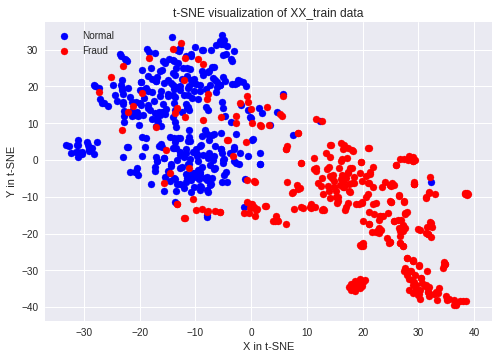

In [22]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
#plt.figure()
#yy = yy_train.Class.values
yy = yy_train.values
allX = XX_train_2d[:,0]
allY = XX_train_2d[:,1]
plt.scatter(x = allX[yy==0], y = allY[yy==0], c = 'blue', label = 'Normal')
plt.scatter(x = allX[yy==1], y = allY[yy==1], c = 'red', label = 'Fraud')
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of XX_train data')
plt.show()

###  3) Stratification approach: GNG + COM

Probably not relevant for this data which is not that small...

# Boosting methods
- XGBoost [x]
- LightGBM
- CatBoost

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Useful functions
def get_auc(m, Xtrain,ytrain, Xtest,ytest): 
    return (metrics.roc_auc_score(ytrain,m.predict_proba(Xtrain)[:,1]),
            metrics.roc_auc_score(ytest,m.predict_proba(Xtest)[:,1]))

def get_metrics(model,XX,yy):    
    cnf_matrix = confusion_matrix(yy,model.predict(XX))
    # Get scores
    res = ji_get_metrics(cnf_matrix)
    print(" Precision: %1.2f"%(res.Precision))
    print(" Recall(TPR): %1.2f"%(res.Recall))
    print(" BAcc=(TPR+TNR)/2: %1.2f"%(res.BAcc))
    
    return res

# XGBoost

In [24]:
# XGBoost
# Install with conda:
# - Check file to instal: anaconda search -t conda xgboost
# - conda install -c mndrake xgboost (IF mndrake is listed...)

import xgboost as xgb
from sklearn import metrics

# Wraper function: Tune + Train + Test
def run_XGBoost(XX_train,yy_train,XX_test,yy_test,explabel,flag):
    tic = time.time()

    # 1) Parameter Tuning    
    model = xgb.XGBClassifier()
    if flag.set2use==0:
        param_dist = {"max_depth": [10,30,50], # 27 combinations
                  "min_child_weight" : [1,3,6],
                  "n_estimators": [200],
                  "learning_rate": [0.01,0.05, 0.1]}
    else: # 125 combinations
        param_dist = {"max_depth": [10,30,50,70,90],
                  "min_child_weight" : [1,3,6,9,12],
                  "n_estimators": [200],
                  "learning_rate": [0.01,0.05, 0.1,0.15,0.2],}

    if flag.pars2use:
        best = flag.pars2use
        print('Using parameters:', best)
    else:
        # Grid search
        grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3,verbose=1, n_jobs=-1)
        grid_search.fit(XX_train, yy_train)
        toc = time.time()
        print("Computation time (parameter tunning): %d seconds..."%(toc-tic))   
        best = grid_search.best_params_
        print('Best parameters:', best)
    
    # 3) Run with best parameters
    tic = time.time()
    model = xgb.XGBClassifier(max_depth=best['max_depth'], min_child_weight=best['min_child_weight'], \
                              n_estimators=best['n_estimators'],n_jobs=-1 , verbose=1,learning_rate=best['learning_rate'])
    model.fit(XX_train,yy_train)

    # Evaluate
    print('********** SUMMARY: XGBoost (%s) **************'%(explabel))
    print('- Parameters used: ',best)
    print('- AUC(Train|Test): ',get_auc(model,XX_train,yy_train,XX_test,yy_test))
    print('- Metrics: Train data (n=%d) **'%len(yy_train))
    res_train = get_metrics(model,XX_train,yy_train)
    print('- Metrics: Test data (n=%d) **'%len(yy_test))
    res_test = get_metrics(model,XX_test,yy_test)

    toc = time.time()
    print("Computation time (Total): %d seconds"%(toc-tic))
    
    return best

In [219]:
## EXPERIMENT 1 - Train data: undersampled, Test data: all

# 1) Choose dataset
mylabel = 'Exp1-Undersampled'
XX_train = X_undersampled.copy()
yy_train = y_undersampled.copy()

XX_test = X_test.copy()
yy_test = y_test.copy()
# 2) Run wrapper
flag = matlab_like()
flag.set2use = 1
flag.pars2use = {}
best1 = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    5.1s finished


Computation time (parameter tunning): 5 seconds...
Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp1-Undersampled) **************
- Parameters used:  {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99980182322631783, 0.98394699169327249)
- Metrics: Train data (n=696) **
 TN=348, FP=0
 FN=6, TP=342
 Precision: 1.00
 Recall(TPR): 0.98
 BAcc=(TPR+TNR)/2: 0.99
- Metrics: Test data (n=85443) **
 TN=82434, FP=2865
 FN=15, TP=129
 Precision: 0.04
 Recall(TPR): 0.90
 BAcc=(TPR+TNR)/2: 0.93
Computation time (Total): 0 seconds


In [220]:
## EXPERIMENT 2 - Train data: undersampled, Test data: all (normalized data)

# 1) Choose dataset
mylabel = 'Exp2-Undersampled (normalized)'
XX_train = ji_normalize(X_undersampled,'standardize',[])
yy_train = y_undersampled.copy()

XX_test = ji_normalize(X_test,'standardize',[])
yy_test = y_test.copy()
# 2) Run wrapper
flag = matlab_like()
flag.set2use = 1
flag.pars2use = {}
best2 = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    5.1s finished


Computation time (parameter tunning): 5 seconds...
Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp2-Undersampled (normalized)) **************
- Parameters used:  {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99980182322631783, 0.94721838767160227)
- Metrics: Train data (n=696) **
 TN=348, FP=0
 FN=6, TP=342
 Precision: 1.00
 Recall(TPR): 0.98
 BAcc=(TPR+TNR)/2: 0.99
- Metrics: Test data (n=85443) **
 TN=9371, FP=75928
 FN=1, TP=143
 Precision: 0.00
 Recall(TPR): 0.99
 BAcc=(TPR+TNR)/2: 0.55
Computation time (Total): 0 seconds


In [224]:
## EXPERIMENT 3 - Train data: SMOTE, Test data: all (best parameters from Exp1)

# 1) Choose dataset
mylabel = 'Exp3-SMOTE (best parameters:Exp1)'
XX_train = X_train_SMOTE.copy()
yy_train = y_train_SMOTE.copy()
XX_test = X_test.copy()
yy_test = y_test.copy()
# 2) Run wrapper
flag = matlab_like()
flag.set2use = 0 # smaller set
flag.pars2use = best1 # will not run GridSearch if selected
run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Using parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp3-SMOTE (best parameters:Exp1)) **************
- Parameters used:  {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99999814343887916, 0.98250410972643953)
- Metrics: Train data (n=398032) **
 TN=198986, FP=30
 FN=0, TP=199016
 Precision: 1.00
 Recall(TPR): 1.00
 BAcc=(TPR+TNR)/2: 1.00
- Metrics: Test data (n=85443) **
 TN=85266, FP=33
 FN=20, TP=124
 Precision: 0.79
 Recall(TPR): 0.86
 BAcc=(TPR+TNR)/2: 0.93
Computation time (Total): 87 seconds


{'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 200}

In [226]:
## EXPERIMENT 4 - Train data: SMOTE2, Test data: all (best parameters from Exp1)

# 1) Choose dataset
mylabel = 'Exp4-SMOTE2 (best parameters:Exp1)'
XX_train = X_train_SMOTE2.copy()
yy_train = y_train_SMOTE2.copy()
XX_test = X_test.copy()
yy_test = y_test.copy()
# 2) Run wrapper
flag = matlab_like()
flag.set2use = 0 # smaller set
flag.pars2use = best1 # will not run GridSearch if selected
tmp = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Using parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp4-SMOTE2 (best parameters:Exp1)) **************
- Parameters used:  {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99999833710233976, 0.98295973738131626)
- Metrics: Train data (n=398032) **
 TN=198996, FP=20
 FN=35, TP=198981
 Precision: 1.00
 Recall(TPR): 1.00
 BAcc=(TPR+TNR)/2: 1.00
- Metrics: Test data (n=85443) **
 TN=85275, FP=24
 FN=23, TP=121
 Precision: 0.83
 Recall(TPR): 0.84
 BAcc=(TPR+TNR)/2: 0.92
Computation time (Total): 76 seconds


In [235]:
## EXPERIMENT 5 - Train data: SMOTE + Selected Feats, Test data: all (best parameters from Undersampled data)

# 1) Choose dataset
mylabel = 'Exp5-SMOTE (best parameters from Undersampled)'
iselected = X_train.columns[select_feature1.get_support()] # Univariate ANOVA
XX_train = X_train_SMOTE[iselected].copy()
yy_train = y_train_SMOTE.copy()
XX_test = X_test[iselected].copy()
yy_test = y_test.copy()
# 2) Get best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 1 # smaller set
flag.pars2use = {} # will not run GridSearch if selected
best5 = run_XGBoost(X_undersampled[iselected],y_undersampled,XX_test,yy_test,'Exp5-Undersampled',flag)
# 3) Run on whole data with the best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 0 # smaller set
flag.pars2use = best5 # will not run GridSearch if selected
best5 = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 344 out of 375 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    3.2s finished


Computation time (parameter tunning): 3 seconds...
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp5-Undersampled) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99272526093275193, 0.9776254378389222)
- Metrics: Train data (n=696) **
 TN=339, FP=9
 FN=26, TP=322
 Precision: 0.97
 Recall(TPR): 0.93
 BAcc=(TPR+TNR)/2: 0.95
- Metrics: Test data (n=85443) **
 TN=82646, FP=2653
 FN=17, TP=127
 Precision: 0.05
 Recall(TPR): 0.88
 BAcc=(TPR+TNR)/2: 0.93
Computation time (Total): 0 seconds
Using parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp5-SMOTE (best parameters from Undersampled)) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99986035

In [236]:
## EXPERIMENT 6 - Train data: SMOTE2 + Selected Feats, Test data: all (best parameters from Undersampled data)

# 1) Choose dataset
mylabel = 'Exp6-SMOTE2 (best parameters from Undersampled)'
iselected = X_train.columns[select_feature1.get_support()] # Univariate ANOVA
XX_train = X_train_SMOTE2[iselected].copy()
yy_train = y_train_SMOTE2.copy()
XX_test = X_test[iselected].copy()
yy_test = y_test.copy()
# 2) Get best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 1 # smaller set
flag.pars2use = {} # will not run GridSearch if selected
best6 = run_XGBoost(X_undersampled[iselected],y_undersampled,XX_test,yy_test,'Exp6-Undersampled',flag)
# 3) Run on whole data with the best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 0 # smaller set
flag.pars2use = best6 # will not run GridSearch if selected
tmp = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    3.2s finished


Computation time (parameter tunning): 3 seconds...
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp6-Undersampled) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.99272526093275193, 0.9776254378389222)
- Metrics: Train data (n=696) **
 TN=339, FP=9
 FN=26, TP=322
 Precision: 0.97
 Recall(TPR): 0.93
 BAcc=(TPR+TNR)/2: 0.95
- Metrics: Test data (n=85443) **
 TN=82646, FP=2653
 FN=17, TP=127
 Precision: 0.05
 Recall(TPR): 0.88
 BAcc=(TPR+TNR)/2: 0.93
Computation time (Total): 0 seconds
Using parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp6-SMOTE2 (best parameters from Undersampled)) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}
- AUC(Train|Test):  (0.9998670

In [238]:
## EXPERIMENT 7 - Train data: SMOTE2 + Selected Feats (Chi2), Test data: all (best parameters from Undersampled data)

# 1) Choose dataset
mylabel = 'Exp7-SMOTE2 (best parameters from Undersampled)'
iselected = X_train.columns[select_feature2.get_support()] # Chi2
print('Selected feats: ',iselected)
XX_train = X_train_SMOTE2[iselected].copy()
yy_train = y_train_SMOTE2.copy()
XX_test = X_test[iselected].copy()
yy_test = y_test.copy()
# 2) Get best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 1 # smaller set
flag.pars2use = {} # will not run GridSearch if selected
tmp = run_XGBoost(X_undersampled[iselected],y_undersampled,XX_test,yy_test,'Exp7-Undersampled',flag)
# 3) Run on whole data with the best parameters from Undersampled data
flag = matlab_like()
flag.set2use = 0 # smaller set
flag.pars2use = tmp # will not run GridSearch if selected
best7 = run_XGBoost(XX_train,yy_train,XX_test,yy_test,mylabel,flag)

Selected feats:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'Amount'],
      dtype='object')
Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 344 out of 375 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    3.1s finished


Computation time (parameter tunning): 4 seconds...
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp7-Undersampled) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200}
- AUC(Train|Test):  (0.99997522790328974, 0.97433619125403315)
- Metrics: Train data (n=696) **
 TN=348, FP=0
 FN=4, TP=344
 Precision: 1.00
 Recall(TPR): 0.99
 BAcc=(TPR+TNR)/2: 0.99
- Metrics: Test data (n=85443) **
 TN=80522, FP=4777
 FN=13, TP=131
 Precision: 0.03
 Recall(TPR): 0.91
 BAcc=(TPR+TNR)/2: 0.93
Computation time (Total): 0 seconds
Using parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200}
********** SUMMARY: XGBoost (Exp7-SMOTE2 (best parameters from Undersampled)) **************
- Parameters used:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200}
- AUC(Train|Test):  (0.9998634